## Import the necessary library

In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents.utils import OUNoise

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Method to plot the progress of the agent's score

In [ ]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [ ]:
def train(agent, n_episodes=500, noise = 1, noise_reduction=0.9999, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(2)
        # reset the noise
        agent.reset()
        while True:
            actions = agent.act(states, noise=noise)              # select an action (for each agent)
            
            # Concatenate all states and actions taken by all agents
            # from agent 0 point of view, concatenate state seen by agent 0, state seen by agent 1, action agent 0, action agent 1
            # from agent 1 point of view, concatenate state seen by agent 1, state seen by agent 0, action agent 1, action agent 0
                
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]              # send all actions to the environment
            next_states = env_info.vector_observations                            # get next state (for each agent)
            rewards = env_info.rewards                                            # get reward (for each agent)
            # lets try to promote cooperation
            common_rewards = np.array(rewards)
            common_rewards.fill(np.sum(common_rewards))
            dones = env_info.local_done                                           # see if episode finished
            agent.step(states, actions, common_rewards, next_states, dones)       # learn
            states = next_states                                                  # roll over states to next time step
            
            scores_one_episode += rewards
            if np.any(dones):                                                     # exit loop if episode finished
                break
                
        noise = max(noise * noise_reduction, 0.01)        
        score = np.max(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMax Score: {:.3f}\tNoise: {:.3f}'.
                      format(i_episode, 
                         mean_100, 
                         np.max(scores_window),
                        noise))
            agent.save("eps_{}_avg_{}.pth".format(i_episode, mean_100))
            
        if len(scores_window) >= 100 and np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("final.pth")
            break
            
    return scores

## Prepare the agent
* One instance of the memory ReplayBuffer is built here
* The ParallelDDPG is one version of the DDPG that use one local actor/critic network and one target actor/critic network that are being used by several agents
* The hyperparameters are set and the agent is initialized
* Several instances of the noise generator are created and attached to the agent

Episode 50	Average Score: 0.008	Max Score: 0.100	Noise: 0.980
Episode 100	Average Score: 0.004	Max Score: 0.100	Noise: 0.961
Episode 150	Average Score: 0.003	Max Score: 0.100	Noise: 0.942
Episode 200	Average Score: 0.012	Max Score: 0.100	Noise: 0.923
Episode 250	Average Score: 0.019	Max Score: 0.100	Noise: 0.905
Episode 300	Average Score: 0.015	Max Score: 0.100	Noise: 0.887
Episode 350	Average Score: 0.015	Max Score: 0.100	Noise: 0.869
Episode 400	Average Score: 0.023	Max Score: 0.100	Noise: 0.852
Episode 450	Average Score: 0.024	Max Score: 0.100	Noise: 0.835
Episode 500	Average Score: 0.032	Max Score: 0.200	Noise: 0.819
Episode 550	Average Score: 0.039	Max Score: 0.200	Noise: 0.802
Episode 600	Average Score: 0.029	Max Score: 0.100	Noise: 0.787
Episode 650	Average Score: 0.017	Max Score: 0.100	Noise: 0.771
Episode 700	Average Score: 0.008	Max Score: 0.100	Noise: 0.756
Episode 750	Average Score: 0.008	Max Score: 0.100	Noise: 0.741
Episode 800	Average Score: 0.009	Max Score: 0.100	Noise:

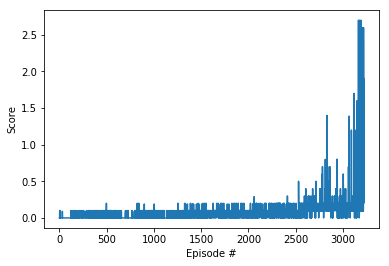

In [7]:
from agents.utils import ReplayBuffer, SimpleNoise
from agents.maddpg import MADDPG
from agents.model import ActorCritic
import torch.nn.functional as F
import random

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
seed = 257
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
memory = ReplayBuffer(action_size, device, int(5e4), 64, seed)
agent = MADDPG(states.shape[1], action_size, states.shape[0], memory, ActorCritic, device,
                    GRADIENT_CLIP = 5,
                    ACTIVATION = F.relu,
                    TAU=1e-3,
                    UPDATE_EVERY=32,
                    TRANSFER_EVERY=2,
                    UPDATE_LOOP=16,
                    ADD_NOISE_EVERY=1,
                    BOOTSTRAP_SIZE=4,
                    LR_CRITIC = 3e-4,
                    LR_ACTOR = 3e-4)

noises = [SimpleNoise(action_size, scale=1) for i in range(int(states.shape[1]))] 
agent.set_noise(noises)
scores = train(agent, n_episodes=60000, noise = 1, noise_reduction = 0.9996, train_mode=True)
plot_result(scores)

## Continue the training with small noise

Episode 50	Average Score: 0.127	Max Score: 1.400	Noise: 0.010
Episode 100	Average Score: 0.113	Max Score: 1.400	Noise: 0.010
Episode 150	Average Score: 0.099	Max Score: 0.200	Noise: 0.010
Episode 200	Average Score: 0.114	Max Score: 1.200	Noise: 0.010
Episode 250	Average Score: 0.120	Max Score: 1.200	Noise: 0.010
Episode 300	Average Score: 0.103	Max Score: 0.300	Noise: 0.010
Episode 350	Average Score: 0.093	Max Score: 0.300	Noise: 0.010
Episode 400	Average Score: 0.095	Max Score: 0.900	Noise: 0.010
Episode 450	Average Score: 0.088	Max Score: 0.900	Noise: 0.010
Episode 500	Average Score: 0.087	Max Score: 0.200	Noise: 0.010
Episode 550	Average Score: 0.095	Max Score: 0.200	Noise: 0.010
Episode 600	Average Score: 0.096	Max Score: 0.100	Noise: 0.010
Episode 650	Average Score: 0.100	Max Score: 0.200	Noise: 0.010
Episode 700	Average Score: 0.151	Max Score: 2.000	Noise: 0.010
Episode 750	Average Score: 0.156	Max Score: 2.000	Noise: 0.010
Episode 800	Average Score: 0.151	Max Score: 2.600	Noise:

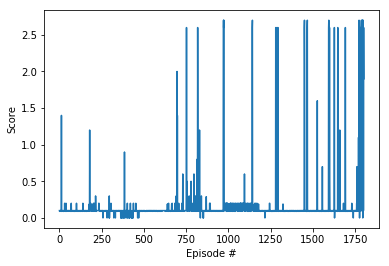

In [22]:
scores = train(agent, n_episodes=2000, noise = 0.01, noise_reduction = 0.9996, train_mode=True)
plot_result(scores)

## View the trained agent

In [5]:
from agents.model import ActorCritic
import torch.nn.functional as F
device = "cpu"
network = ActorCritic(state_size, action_size, state_size * 2 , F.leaky_relu ).to(device)
network.eval()
network.load_state_dict(torch.load("./final_weights/final_maddpg_local.pth"))
env_info = env.reset(train_mode=False)[brain_name]

def act(network, states, device):
    states = torch.from_numpy(states).float().unsqueeze(0).to(device)
    ret = network(states).squeeze().cpu().data.numpy()
    return ret

for i in range(5):
    while True:
        actions = act(network, states, device)
        env_info = env.step(np.clip(actions, -1, 1))[brain_name]  # send all actions to the environment
        states = env_info.vector_observations                     # get next state (for each agent)
        dones = env_info.local_done                               # see if episode finished
        if np.any(dones):                                         # exit loop if episode finished
            break